# Project Summary

## Business Objective

## Data Options

## Executive Summary

# Data Load & Prep


## Import Libraries


In [2]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# set display options to remove scientific notation and allow dataframe rows to display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("max_rows", None)

## Source Dataframes

### Load IMBD Basics

In [3]:
# Load IMDB Basics as title master, set index and convert minutes from float
imdb_basics = pd.read_csv('data/imdb.title.basics.csv')
imdb_basics['runtime_minutes'] = imdb_basics['runtime_minutes'].astype('Int64')

### Load IMDB Ratings

In [4]:
# Load IMDB Ratings, set index, standarized column names and convert votes to integer
imdb_ratings = pd.read_csv('data/imdb.title.ratings.csv')
imdb_ratings.rename(columns={'averagerating': "avg_rating", 'numvotes': 'num_votes'}, inplace=True)
imdb_ratings['num_votes'] = imdb_ratings['num_votes'].astype('Int64')

In [45]:
movies[movies['primary_title']=='Foodfight!']

,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind,studio,domestic_gross_x,foreign_gross,gross_ind,title_cnt,production_budget,domestic_gross_y,worldwide_gross,worldwide_profit,profit_margin,tn_ind
20,tt0249516,Foodfight!,2012,91,"Action,Animation,Comedy",1.90,8248,both,NaN,<NA>,<NA>,left_only,1,"45,000,000.00",0.00,"73,706.00","-44,926,294.00",-99.84,both


### Load BOM Movie Gross

In [5]:
# Load BOM Movie Gross, transform gross columns from mixed data types into integer
bom = pd.read_csv('data/bom.movie_gross.csv')
bom['domestic_gross'].replace('"', '', inplace=True)
bom['domestic_gross'].fillna(0, inplace=True)
bom['domestic_gross'] = bom['domestic_gross'].astype('Int64')
bom['foreign_gross'] = bom['foreign_gross'].str.replace(',', '')
bom['foreign_gross'].fillna(0, inplace=True)
bom['foreign_gross'] = bom['foreign_gross'].astype('float').round(0).astype('Int64')

### Load TN Movie Budgets

In [6]:
# Load TN Budget, transform gross columns from mixed data types into integer
tn = pd.read_csv('data/tn.movie_budgets.csv')
tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [7]:
# Convert Date and create Year
tn['movie'] = tn['movie'].str.encode('ascii', 'ignore').str.decode('ascii')
tn['release_date'] = pd.to_datetime(tn['release_date'], infer_datetime_format=True).dt.floor('d')
tn['year'] = tn['release_date'].dt.year
currency_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
tn[currency_cols] = tn[currency_cols].apply(lambda x: x.str.replace('$', '').str.replace(',', ''))
tn[currency_cols] = tn[currency_cols].astype('float')
tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
0,1,2009-12-18,Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00",2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00",2011
2,3,2019-06-07,Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00",2019
3,4,2015-05-01,Avengers: Age of Ultron,"330,600,000.00","459,005,868.00","1,403,013,963.00",2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"317,000,000.00","620,181,382.00","1,316,721,747.00",2017


In [8]:
# Clean up duplicate row - single movie found in data profiling
home1 = tn[(tn['movie'] == 'Home') & (tn['release_date'] == '2009-04-23')] #more complete record
home2 = tn[(tn['movie'] == 'Home') & (tn['release_date'] == '2009-06-05')] #contains budget $12m
home2_budget = home2['production_budget'].sum()
home1['production_budget'] = home1['production_budget'] + home2_budget

# Update/drop duplicate
tn.drop(home2.index, inplace = True)
tn.update(home1)

#Validation
display(tn[(tn['movie'] == 'Home') ])
tn.head()

<ipython-input-8-5b78ee3ab015>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home1['production_budget'] = home1['production_budget'] + home2_budget


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
243,44.00,2015-03-27,Home,"130,000,000.00","177,397,510.00","385,997,896.00","2,015.00"
5459,60.00,2009-04-23,Home,"12,500,000.00","15,433.00","44,793,168.00","2,009.00"


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
0,1.00,2009-12-18,Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00","2,009.00"
1,2.00,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00","2,011.00"
2,3.00,2019-06-07,Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00","2,019.00"
3,4.00,2015-05-01,Avengers: Age of Ultron,"330,600,000.00","459,005,868.00","1,403,013,963.00","2,015.00"
4,5.00,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"317,000,000.00","620,181,382.00","1,316,721,747.00","2,017.00"


In [9]:
# Transform some columns
tn['worldwide_profit'] = tn['worldwide_gross'] - tn['production_budget']
tn['profit_margin'] = (tn['worldwide_profit'] / tn['production_budget'])*100
tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,worldwide_profit,profit_margin
0,1.00,2009-12-18,Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00","2,009.00","2,351,345,279.00",553.26
1,2.00,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00","2,011.00","635,063,875.00",154.67
2,3.00,2019-06-07,Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00","2,019.00","-200,237,650.00",-57.21
3,4.00,2015-05-01,Avengers: Age of Ultron,"330,600,000.00","459,005,868.00","1,403,013,963.00","2,015.00","1,072,413,963.00",324.38
4,5.00,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"317,000,000.00","620,181,382.00","1,316,721,747.00","2,017.00","999,721,747.00",315.37


## Data Profiling

### IMDB Basics Checks

In [10]:
# IMDB Basics import and data quality check

print(imdb_basics.head(2))
imdb_basics.info() # Nulls 31K minutes, 5K genre
imdb_basics['start_year'].value_counts(sort=True) #Ranges 2010 - 2019 partial (some future)
imdb_basics['genres'].value_counts(sort=True) #Majority single genres but 1085 combinations

      tconst                    primary_title   original_title  start_year  \
0  tt0063540                        Sunghursh        Sunghursh        2013   
1  tt0066787  One Day Before the Rainy Season  Ashad Ka Ek Din        2019   

   runtime_minutes              genres  
0              175  Action,Crime,Drama  
1              114     Biography,Drama  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   tconst           146144 non-null  object
 1   primary_title    146144 non-null  object
 2   original_title   146123 non-null  object
 3   start_year       146144 non-null  int64 
 4   runtime_minutes  114405 non-null  Int64 
 5   genres           140736 non-null  object
dtypes: Int64(1), int64(1), object(4)
memory usage: 6.8+ MB


Documentary                         32185
Drama                               21486
Comedy                               9177
Horror                               4372
Comedy,Drama                         3519
Thriller                             3046
Action                               2219
Biography,Documentary                2115
Drama,Romance                        2079
Comedy,Drama,Romance                 1558
Documentary,Drama                    1554
Comedy,Romance                       1507
Romance                              1454
Documentary,Music                    1365
Drama,Thriller                       1335
Documentary,History                  1289
Horror,Thriller                      1253
Biography,Documentary,History        1230
Biography,Documentary,Drama          1028
Family                                939
Animation                             828
Drama,Family                          784
Action,Crime,Drama                    727
Comedy,Horror                     

In [11]:
imdb_basics.duplicated(['tconst'],keep=False).sum() #No dups
imdb_basics.duplicated(['primary_title','start_year'],keep=False).sum() #3942 dups


3942

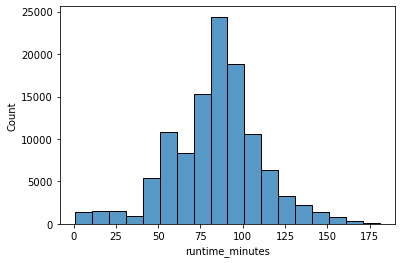

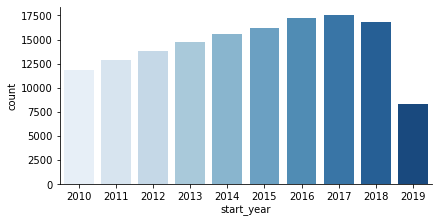

In [12]:
# Review distribution plots
length180 = imdb_basics[imdb_basics['runtime_minutes'] < 180]
sns.histplot(data=length180, x='runtime_minutes', binwidth=10, palette='Blues')

keepyears = imdb_basics[imdb_basics['start_year'].between(2010,2019)]
sns.catplot(data=keepyears, kind='count', x='start_year', palette='Blues', height=3, aspect=2)


### IMDB Ratings Checks

In [13]:
# 
imdb_ratings.head()
imdb_ratings.info()
imdb_ratings.duplicated(['tconst'],keep=False).sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tconst      73856 non-null  object 
 1   avg_rating  73856 non-null  float64
 2   num_votes   73856 non-null  Int64  
dtypes: Int64(1), float64(1), object(1)
memory usage: 1.8+ MB


0

### BOM Movie Gross Checks

In [14]:
# BOM Movie Gross File - explore data quality
print(bom.head(2))
print(bom.info()) # Nulls 31K minutes, 5K genre
print(bom.describe())
bom['year'].value_counts(sort=True) #Ranges 2010 - 2019 partial (some future)
bom['studio'].value_counts(sort=True) #Majority single genres but 1085 combinations

                        title studio  domestic_gross  foreign_gross  year
0                 Toy Story 3     BV       415000000      652000000  2010
1  Alice in Wonderland (2010)     BV       334200000      691300000  2010
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           3387 non-null   object
 1   studio          3382 non-null   object
 2   domestic_gross  3387 non-null   Int64 
 3   foreign_gross   3387 non-null   Int64 
 4   year            3387 non-null   int64 
dtypes: Int64(2), int64(1), object(2)
memory usage: 139.0+ KB
None
       domestic_gross  foreign_gross     year
count        3,387.00       3,387.00 3,387.00
mean    28,508,205.96  45,029,794.59 2,013.96
std     66,755,749.11 112,684,345.89     2.48
min              0.00           0.00 2,010.00
25%        111,500.00           0.00 2,012.00
50%      1,300,000.00

IFC             166
Uni.            147
WB              140
Fox             136
Magn.           136
SPC             123
Sony            110
BV              106
LGF             103
Par.            101
Eros             89
Wein.            77
CL               74
Strand           68
FoxS             67
RAtt.            66
KL               62
Focus            60
WGUSA            58
CJ               56
MBox             54
UTV              50
A24              49
WB (NL)          45
FM               42
LG/S             41
Cohen            40
ORF              37
Rela.            35
SGem             35
FIP              26
STX              24
Gold.            24
GK               24
TriS             23
Osci.            23
RTWC             23
MNE              22
BST              22
EOne             21
Drft.            20
Distrib.         20
Relbig.          18
Anch.            18
CBS              17
BG               16
Zeit.            16
Sum.             15
FD               14
W/Dim.           14


In [ ]:
print(f"\n**{bom.duplicated(['title'],keep=False).sum()} duplicates found based on title**\n") #No dups
print(f"\n**{bom.duplicated(['title'],keep=False)} duplicates found based on title**\n") #No dups

### TN Movie Budgets Checks

In [15]:
# TN Budgets File - explore data quality
display(tn.head(2))
display(tn.info()) # Nulls 31K minutes, 5K genre
print(tn.describe())
tn.groupby(by='year').sum().sort_values(by='year', ascending=False).head(10) #Consistent data through 2016 then drop

tn.duplicated(['movie','year'],keep=False).sum()
tn[tn.duplicated(['movie','year'],keep=False)]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,worldwide_profit,profit_margin
0,1.00,2009-12-18,Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00","2,009.00","2,351,345,279.00",553.26
1,2.00,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00","2,011.00","635,063,875.00",154.67


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5781 entries, 0 to 5781
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5781 non-null   float64       
 1   release_date       5781 non-null   datetime64[ns]
 2   movie              5781 non-null   object        
 3   production_budget  5781 non-null   float64       
 4   domestic_gross     5781 non-null   float64       
 5   worldwide_gross    5781 non-null   float64       
 6   year               5781 non-null   float64       
 7   worldwide_profit   5781 non-null   float64       
 8   profit_margin      5781 non-null   float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 451.6+ KB


None

            id  production_budget  domestic_gross  worldwide_gross     year  \
count 5,781.00           5,781.00        5,781.00         5,781.00 5,781.00   
mean     50.37      31,593,221.16   41,880,570.13    91,503,286.45 2,003.97   
std      28.82      41,813,653.90   68,244,277.37   174,730,937.87    12.73   
min       1.00           1,100.00            0.00             0.00 1,915.00   
25%      25.00       5,000,000.00    1,430,241.00     4,128,828.00 2,000.00   
50%      50.00      17,000,000.00   17,231,291.00    27,989,498.00 2,007.00   
75%      75.00      40,000,000.00   52,353,636.00    97,651,543.00 2,012.00   
max     100.00     425,000,000.00  936,662,225.00 2,776,345,279.00 2,020.00   

       worldwide_profit  profit_margin  
count          5,781.00       5,781.00  
mean      59,910,065.29         378.61  
std      146,098,763.77       2,951.17  
min     -200,237,650.00        -100.00  
25%       -2,178,990.00         -50.71  
50%        8,554,727.00          70.90  
7

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,worldwide_profit,profit_margin


# Feature Engineering

## Create Movies Dataframe

### Join IMDB Basics + Ratings

In [16]:
# Create Movies DF - basics left join to ratings and bom 
movies = imdb_basics.merge(imdb_ratings, how='left', left_on='tconst', right_on='tconst', indicator='rating_ind')
movies.drop(columns=['original_title'], inplace=True)
movies.head()

,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind
0,tt0063540,Sunghursh,2013,175,"Action,Crime,Drama",7.00,77,both
1,tt0066787,One Day Before the Rainy Season,2019,114,"Biography,Drama",7.20,43,both
2,tt0069049,The Other Side of the Wind,2018,122,Drama,6.90,4517,both
3,tt0069204,Sabse Bada Sukh,2018,<NA>,"Comedy,Drama",6.10,13,both
4,tt0100275,The Wandering Soap Opera,2017,80,"Comedy,Drama,Fantasy",6.50,119,both


### Deduplicate Movie Titles

In [18]:
#movies.duplicated(['primary_title','start_year'],keep=False).sum() #3942 dups
dups = movies[movies.duplicated(subset=['primary_title','start_year'],keep=False)]
dups.sort_values(['primary_title','start_year','num_votes','runtime_minutes'], ascending=[True, True, True, True], na_position='first', inplace=True)
dups_remove = dups[dups.duplicated(subset=['primary_title','start_year'],keep='last') == True]
dups_keep = dups[dups.duplicated(subset=['primary_title','start_year'],keep='last') == False]
movies.drop(dups_remove.index, inplace = True)

#Validations
display(dups_keep.duplicated(['primary_title','start_year'],keep=False).sum())
display(movies.duplicated(['primary_title','start_year'], keep=False).sum()) #0 dups
movies[movies['primary_title']=='Alice in Wonderland']

<ipython-input-18-06e5d8b5a5f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dups.sort_values(['primary_title','start_year','num_votes','runtime_minutes'], ascending=[True, True, True, True], na_position='first', inplace=True)


0

0

,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind
1608,tt1014759,Alice in Wonderland,2010,108,"Adventure,Family,Fantasy",6.50,358813,both
22538,tt1926979,Alice in Wonderland,2011,48,Documentary,nan,<NA>,left_only


### Merge BOM Movie Gross

In [19]:
movies = movies.merge(bom, how='left', left_on='primary_title', right_on='title', indicator='gross_ind')
movies.drop(columns=['title','year'], inplace=True)
movies['title_cnt'] = 1

In [20]:
movies.groupby(['rating_ind','gross_ind']).size() # 98% have ratings, less than 5% have gross sales


rating_ind  gross_ind 
left_only   left_only     70537
            right_only        0
            both            264
right_only  left_only         0
            right_only        0
            both              0
both        left_only     70315
            right_only        0
            both           2958
dtype: int64

### Merge TN Movie Budgets

In [22]:
print(f'Note: TN file has {tn.movie.size} unique titles. IMDB Basics has {movies.primary_title.size}.')

keep = ['movie','year','production_budget','domestic_gross','worldwide_gross','worldwide_profit','profit_margin']
l_keys = ['start_year', 'primary_title']
r_keys = ['year','movie']
movies = movies.merge(tn[keep], how='left', left_on=l_keys, right_on=r_keys, indicator='tn_ind')
movies.drop(columns=['movie','year'], inplace=True)
movies.head()

Note: TN file has 5781 unique titles. IMDB Basics has 144074.


,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind,studio,domestic_gross_x,foreign_gross,gross_ind,title_cnt,production_budget,domestic_gross_y,worldwide_gross,worldwide_profit,profit_margin,tn_ind
0,tt0063540,Sunghursh,2013,175,"Action,Crime,Drama",7.00,77,both,NaN,<NA>,<NA>,left_only,1,nan,nan,nan,nan,nan,left_only
1,tt0066787,One Day Before the Rainy Season,2019,114,"Biography,Drama",7.20,43,both,NaN,<NA>,<NA>,left_only,1,nan,nan,nan,nan,nan,left_only
2,tt0069049,The Other Side of the Wind,2018,122,Drama,6.90,4517,both,NaN,<NA>,<NA>,left_only,1,nan,nan,nan,nan,nan,left_only
3,tt0069204,Sabse Bada Sukh,2018,<NA>,"Comedy,Drama",6.10,13,both,NaN,<NA>,<NA>,left_only,1,nan,nan,nan,nan,nan,left_only
4,tt0100275,The Wandering Soap Opera,2017,80,"Comedy,Drama,Fantasy",6.50,119,both,NaN,<NA>,<NA>,left_only,1,nan,nan,nan,nan,nan,left_only


### Reverse Match TN Movie Budgets

In [23]:
display(movies['tn_ind'].value_counts())

keep = ['primary_title','start_year','tn_ind']
r_keys = ['start_year', 'primary_title']
l_keys = ['year','movie']
tn_reverse = tn.merge(movies[keep], how='left', left_on=l_keys, right_on=r_keys, indicator='movies_ind')

display(tn_reverse['movies_ind'].value_counts())
tn_reverse[tn_reverse['year']>=2010].groupby(['year']).size()

table = pd.pivot_table(tn_reverse[tn_reverse['year']>=2010], values='movie', index='year', columns='movies_ind', aggfunc='count')
table.head(10)

tn_reverse[tn_reverse['movies_ind']=='left_only']
#tn_reverse[tn_reverse['movies_ind']=='both']

left_only     142590
both            1484
right_only         0
Name: tn_ind, dtype: int64

left_only     4297
both          1484
right_only       0
Name: movies_ind, dtype: int64

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,worldwide_profit,profit_margin,primary_title,start_year,tn_ind,movies_ind
0,1.00,2009-12-18,Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00","2,009.00","2,351,345,279.00",553.26,NaN,nan,NaN,left_only
4,5.00,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"317,000,000.00","620,181,382.00","1,316,721,747.00","2,017.00","999,721,747.00",315.37,NaN,nan,NaN,left_only
5,6.00,2015-12-18,Star Wars Ep. VII: The Force Awakens,"306,000,000.00","936,662,225.00","2,053,311,220.00","2,015.00","1,747,311,220.00",571.02,NaN,nan,NaN,left_only
7,8.00,2007-05-24,Pirates of the Caribbean: At Worlds End,"300,000,000.00","309,420,425.00","963,420,425.00","2,007.00","663,420,425.00",221.14,NaN,nan,NaN,left_only
15,16.00,2007-05-04,Spider-Man 3,"258,000,000.00","336,530,303.00","894,860,230.00","2,007.00","636,860,230.00",246.85,NaN,nan,NaN,left_only
19,20.00,2009-07-15,Harry Potter and the Half-Blood Prince,"250,000,000.00","302,089,278.00","935,213,767.00","2,009.00","685,213,767.00",274.09,NaN,nan,NaN,left_only
23,24.00,2006-06-28,Superman Returns,"232,000,000.00","200,120,000.00","374,085,065.00","2,006.00","142,085,065.00",61.24,NaN,nan,NaN,left_only
25,26.00,2008-11-14,Quantum of Solace,"230,000,000.00","169,368,427.00","591,692,078.00","2,008.00","361,692,078.00",157.26,NaN,nan,NaN,left_only
27,28.00,2006-07-07,Pirates of the Caribbean: Dead Mans Chest,"225,000,000.00","423,315,812.00","1,066,215,812.00","2,006.00","841,215,812.00",373.87,NaN,nan,NaN,left_only
29,30.00,2008-05-16,The Chronicles of Narnia: Prince Caspian,"225,000,000.00","141,621,490.00","417,341,288.00","2,008.00","192,341,288.00",85.49,NaN,nan,NaN,left_only


## Featurize Genres

In [24]:
# Concatenate non-null genres series strings together in unique list
genres_list = ','.join(str(x) for x in imdb_basics['genres'].dropna().unique())
# Split genres list into unique set of genres
genres_unique = set(x for x in genres_list.split(','))

# Loop unique genres, create new boolean series for each genre; useful for correlations
for genre in sorted(genres_unique):
    imdb_basics['is_'+genre.lower()] = imdb_basics.apply(lambda x: int(genre in str(x.genres)), axis=1)

imdb_basics.head(50)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,is_action,is_adult,is_adventure,is_animation,...,is_news,is_reality-tv,is_romance,is_sci-fi,is_short,is_sport,is_talk-show,is_thriller,is_war,is_western
0,tt0063540,Sunghursh,Sunghursh,2013,175,"Action,Crime,Drama",1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114,"Biography,Drama",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122,Drama,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,<NA>,"Comedy,Drama",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80,"Comedy,Drama,Fantasy",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,tt0111414,A Thin Life,A Thin Life,2018,75,Comedy,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,tt0112502,Bigfoot,Bigfoot,2017,<NA>,"Horror,Thriller",0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83,"Adventure,Animation,Comedy",0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
8,tt0139613,O Silêncio,O Silêncio,2012,<NA>,"Documentary,History",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82,Biography,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Business Analysis

## Genre Counts & Ratings

Profits = Worldwide Sales - Production Costs
Profit Margins = Profits / Production Costs
Notes: Sales and costs are adjusted by CPI factor, limited data sets have this data.

### Group By Genres

In [25]:
# Top movie genres 2010-2019
year_filter = movies['start_year'].between(2010,2019)
titles = movies[year_filter].groupby('genres', as_index=False).agg(Movie_Count = ('title_cnt', 'sum')).sort_values('Movie_Count', ascending=False)[:20]
titles['Subtotal'] = movies[year_filter].title_cnt.sum()
titles['Pct_Total'] = (titles['Movie_Count']*100 / titles['Subtotal'])
print(titles)


                             genres  Movie_Count  Subtotal  Pct_Total
693                     Documentary        31797    143026      22.23
792                           Drama        20896    143026      14.61
493                          Comedy         9016    143026       6.30
989                          Horror         4254    143026       2.97
526                    Comedy,Drama         3455    143026       2.42
1075                       Thriller         2894    143026       2.02
0                            Action         2124    143026       1.49
432           Biography,Documentary         2087    143026       1.46
870                   Drama,Romance         2038    143026       1.42
536            Comedy,Drama,Romance         1545    143026       1.08
694               Documentary,Drama         1525    143026       1.07
607                  Comedy,Romance         1492    143026       1.04
1058                        Romance         1413    143026       0.99
750               Do

[Text(0.5, 1.0, 'Movies By Genre Type 2010 through 2019')]

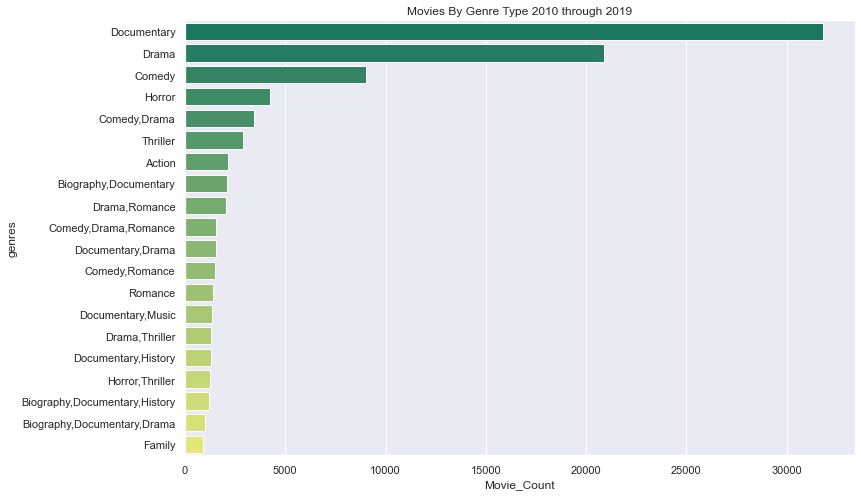

In [26]:
# Plot the top 20 genres by title count from 2010-2019
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")
ax = sns.barplot(data = titles, orient='h', x = 'Movie_Count', y = 'genres', palette='summer')
ax.set(title='Movies By Genre Type 2010 through 2019') # title barplot

### Group By Unique Genre

In [43]:
# Top dervied movie genres 2010-2019
g_cnt_der = movies[['tconst', 'primary_title', 'start_year', 'genres', 'title_cnt', 'runtime_minutes', 'rating_ind', 
                    'avg_rating', 'num_votes', 'tn_ind', 'production_budget', 'domestic_gross_y', 
                    'worldwide_gross', 'worldwide_profit', 'profit_margin']]

g_cnt_der['genres'] = g_cnt_der['genres'].str.split(',')
g_cnt_der['num_genres'] = g_cnt_der['genres'].str.len()
g_cnt_der = g_cnt_der.explode('genres')
g_cnt_der['title_cnt_der'] = g_cnt_der['title_cnt'] / g_cnt_der['num_genres']
genre_list = ['Reality-TV','Talk-Show','Adult','Short','Game-Show']
g_cnt_der = g_cnt_der[(g_cnt_der.start_year.between(2010,2019)) & (~g_cnt_der.genres.isin(genre_list))]
g_cnt_der.head()


<ipython-input-43-5745250ef62f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_cnt_der['genres'] = g_cnt_der['genres'].str.split(',')
<ipython-input-43-5745250ef62f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_cnt_der['num_genres'] = g_cnt_der['genres'].str.len()


,tconst,primary_title,start_year,genres,title_cnt,runtime_minutes,rating_ind,avg_rating,num_votes,tn_ind,production_budget,domestic_gross_y,worldwide_gross,worldwide_profit,profit_margin,num_genres,title_cnt_der
0,tt0063540,Sunghursh,2013,Action,1,175,both,7.00,77,left_only,nan,nan,nan,nan,nan,3.00,0.33
0,tt0063540,Sunghursh,2013,Crime,1,175,both,7.00,77,left_only,nan,nan,nan,nan,nan,3.00,0.33
0,tt0063540,Sunghursh,2013,Drama,1,175,both,7.00,77,left_only,nan,nan,nan,nan,nan,3.00,0.33
1,tt0066787,One Day Before the Rainy Season,2019,Biography,1,114,both,7.20,43,left_only,nan,nan,nan,nan,nan,2.00,0.50
1,tt0066787,One Day Before the Rainy Season,2019,Drama,1,114,both,7.20,43,left_only,nan,nan,nan,nan,nan,2.00,0.50


In [ ]:
titles_der = g_cnt_der.groupby('genres', as_index=False).agg(movie_count = ('title_cnt_der', 'sum'), avg_runtime_mins = ('runtime_minutes', 'mean'), avg_rating_avg = ('avg_rating', 'mean'), num_votes_avg = ('num_votes', 'mean')).sort_values('movie_count', ascending=False)
titles_der['total_movies'] = titles_der['movie_count'].sum()
titles_der['pct_total'] = (titles_der['movie_count']*100 / titles_der['total_movies'])
titles_der

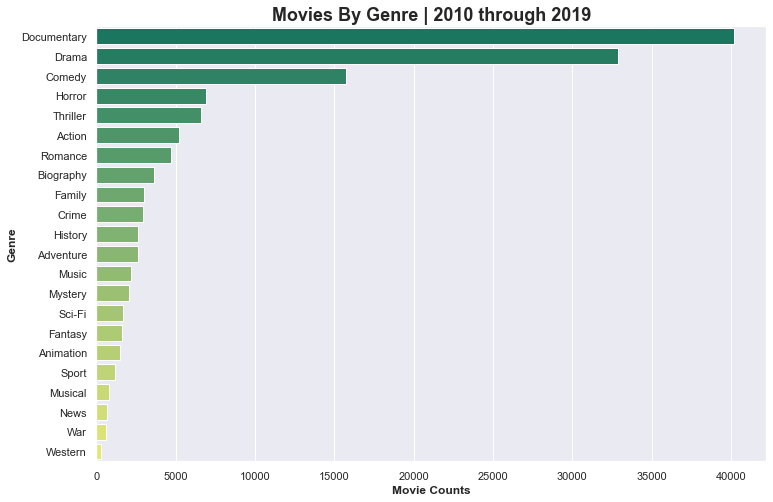

In [11]:
# Plot the top 20 genres by title count from 2010-2019
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")
ax = sns.barplot(data = titles_der, orient='h', x = 'movie_count', y = 'genres', palette='summer')
ax.set_title('Movies By Genre | 2010 through 2019', fontdict= {'fontsize': 18, 'fontweight':'bold'})
ax.set_xlabel('Movie Counts', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 
ax.set_ylabel('Genre', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 
plt.show()
# Possibly add cumulative % 2nd axis

### Counts By Genre Chart

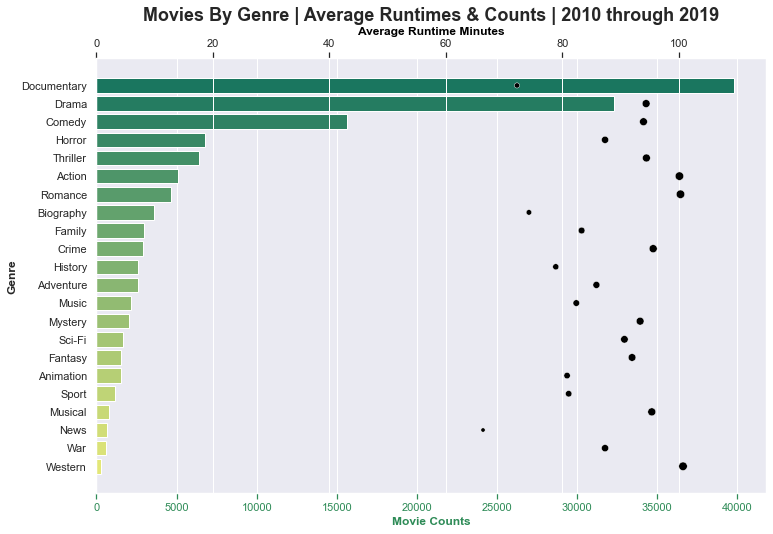

In [28]:
# Plot the top 22 genres by movie count and runtime minutes from 2010-2019
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")
ax_color = 'seagreen'
ax = sns.barplot(data = titles_der, orient='h', x = 'movie_count', y = 'genres', palette='summer')
ax.set_xlabel('Movie Counts', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax_color) 
ax.xaxis.label.set_color(ax_color)
ax.set_xlim(0, None)
ax.tick_params(axis='x', colors=ax_color)
ax.set_title('Movies By Genre | Average Runtimes & Counts | 2010 through 2019', fontdict= {'fontsize': 18, 'fontweight':'bold'})
ax.set_ylabel('Genre', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 

#specify we want to share the same x-axis
ax2 = ax.twiny()
ax2_color = 'black'
ax2 = sns.scatterplot(data = titles_der, x = 'avg_runtime_mins', y = 'genres', color=ax2_color, size='avg_runtime_mins', legend=False)
ax2.set_xlim(0, 115)
ax2.set_xlabel('Average Runtime Minutes', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax2_color)
plt.show()

### Ratings By Genre Chart

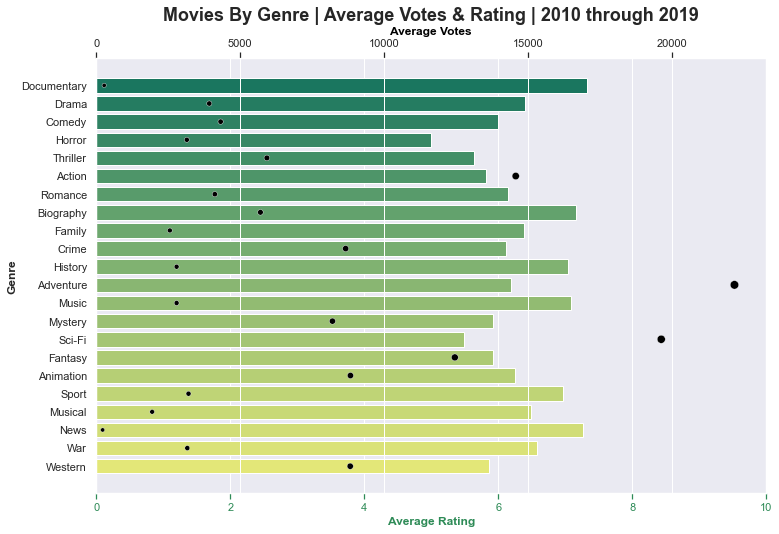

In [29]:
# Plot the top 22 genres by average movie rating and votes from 2010-2019
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")

ax_color = 'seagreen'
ax = sns.barplot(data = titles_der, orient='h', x = 'avg_rating_avg', y = 'genres', palette='summer')
ax.set_xlabel('Average Rating', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax_color) 
ax.xaxis.label.set_color(ax_color)
ax.set_xlim(0, 10)
ax.tick_params(axis='x', colors=ax_color)
ax.set_title('Movies By Genre | Average Votes & Rating | 2010 through 2019', fontdict= {'fontsize': 18, 'fontweight':'bold'})
ax.set_ylabel('Genre', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 

#specify we want to share the same x-axis
ax2 = ax.twiny()
ax2_color = 'black'
ax2 = sns.scatterplot(data = titles_der, x = 'num_votes_avg', y = 'genres', color=ax2_color, size='num_votes_avg', legend=False)
ax2.set_xlim(0, None)
ax2.set_xlabel('Average Votes', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax2_color)

plt.show()

## Genre Profit Correlation

In [44]:
# Convert profits columns using weighted counts
g_cnt_der['production_budget_der'] = g_cnt_der['production_budget'] / g_cnt_der['num_genres']
g_cnt_der['worldwide_gross_der'] = g_cnt_der['worldwide_gross'] / g_cnt_der['num_genres']
g_cnt_der['worldwide_profit_der'] = g_cnt_der['worldwide_profit'] / g_cnt_der['num_genres']
profits = g_cnt_der[g_cnt_der['tn_ind'] == 'both']
profits.head()



,tconst,primary_title,start_year,genres,title_cnt,runtime_minutes,rating_ind,avg_rating,num_votes,tn_ind,production_budget,domestic_gross_y,worldwide_gross,worldwide_profit,profit_margin,num_genres,title_cnt_der,production_budget_der,worldwide_gross_der,worldwide_profit_der
20,tt0249516,Foodfight!,2012,Action,1,91,both,1.90,8248,both,"45,000,000.00",0.00,"73,706.00","-44,926,294.00",-99.84,3.00,0.33,"15,000,000.00","24,568.67","-14,975,431.33"
20,tt0249516,Foodfight!,2012,Animation,1,91,both,1.90,8248,both,"45,000,000.00",0.00,"73,706.00","-44,926,294.00",-99.84,3.00,0.33,"15,000,000.00","24,568.67","-14,975,431.33"
20,tt0249516,Foodfight!,2012,Comedy,1,91,both,1.90,8248,both,"45,000,000.00",0.00,"73,706.00","-44,926,294.00",-99.84,3.00,0.33,"15,000,000.00","24,568.67","-14,975,431.33"
54,tt0359950,The Secret Life of Walter Mitty,2013,Adventure,1,114,both,7.30,275300,both,"91,000,000.00","58,236,838.00","187,861,183.00","96,861,183.00",106.44,3.00,0.33,"30,333,333.33","62,620,394.33","32,287,061.00"
54,tt0359950,The Secret Life of Walter Mitty,2013,Comedy,1,114,both,7.30,275300,both,"91,000,000.00","58,236,838.00","187,861,183.00","96,861,183.00",106.44,3.00,0.33,"30,333,333.33","62,620,394.33","32,287,061.00"


In [ ]:
profits_der = profits.groupby('genres', as_index=False).agg(movie_count = ('title_cnt_der', 'sum'), avg_runtime_mins = ('runtime_minutes', 'mean'), avg_rating_avg = ('avg_rating', 'mean'), num_votes_avg = ('num_votes', 'mean')).sort_values('movie_count', ascending=False)
titles_der['total_movies'] = titles_der['movie_count'].sum()
titles_der['pct_total'] = (titles_der['movie_count']*100 / titles_der['total_movies'])
titles_der



/Users/cutterback/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


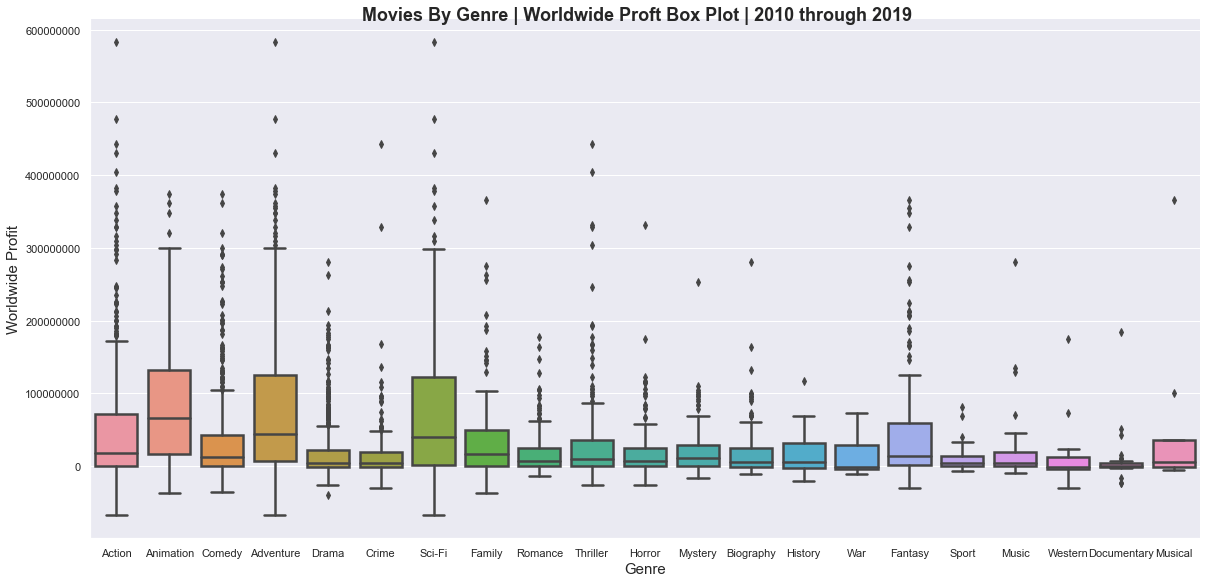

In [77]:
# plot
sns.set(style="darkgrid")
box_profit = sns.catplot(kind="box", data=profits, x="genres", y="worldwide_profit_der", ax=ax, height=8, aspect=2, linewidth=2.5)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Worldwide Profit', fontsize=15)
box_profit.fig.suptitle('Movies By Genre | Worldwide Proft Box Plot | 2010 through 2019', fontsize = 18, fontweight ="bold")
plt.show()

# Appendix

## Deprecated Code

In [ ]:
# IMDB Basics parse and featurize genres
def match_genre(target_genre, title_genres):
    result = 0
    if title_genres: 
        for genre in title_genres:
            if genre == target_genre: 
                result += 1
            else:     
                result += 0
    if result > 0: result = 1
    return result

unique_genres = sorted(imdb_basics['genres'].str.split(pat=",").explode().dropna().unique())
genre_series = imdb_basics['genres'].str.split(pat=",")

for key, genre in genre_series.head(50).items():
    for g in unique_genres:
        match = match_genre(g, genre)
        #print(genre, g, match)
        genre_series[key][g] = match #old method, had error on this line otherwise function working

imdb_basics.head(50)